## Model Comparisons

Load useful libraries

In [1]:
import pandas as pd
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as gnn
from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [2]:
data_dir = Path(".").absolute().parent / "data"
models_dir = data_dir / "models"
results_all_df = pd.read_csv(models_dir / "classification_stats.csv")
results_all_df

,model,pred_target,feature_group,accuracy,f1
0,lr,super_class,node2vec,0.824068,0.514365
1,mlp,super_class,node2vec,0.894460,0.595118
2,lr,super_class,spectral,0.762146,0.344048
3,mlp,super_class,spectral,0.855126,0.491710
4,lr,super_class,both,0.842859,0.556493
5,mlp,super_class,both,0.899036,0.585515
6,lr,class,node2vec,0.889587,0.813777
7,mlp,class,node2vec,0.906741,0.822530
8,lr,class,spectral,0.726021,0.528421
9,mlp,class,spectral,0.893211,0.795145


### Grouped bar chart with labels

In [3]:
results_both = results_all_df[results_all_df.feature_group == 'both']
results_both

,model,pred_target,feature_group,accuracy,f1
4,lr,super_class,both,0.842859,0.556493
5,mlp,super_class,both,0.899036,0.585515
10,lr,class,both,0.902392,0.837038
11,mlp,class,both,0.914472,0.837706
16,lr,hemilineage,both,0.492887,0.564259
17,mlp,hemilineage,both,0.494041,0.571471
20,gcn,super_class,both,0.894614,0.616892
23,gcn,class,both,0.902109,0.840286
26,gcn,hemilineage,both,0.537870,0.576408
29,fp,super_class,both,0.896345,0.645652


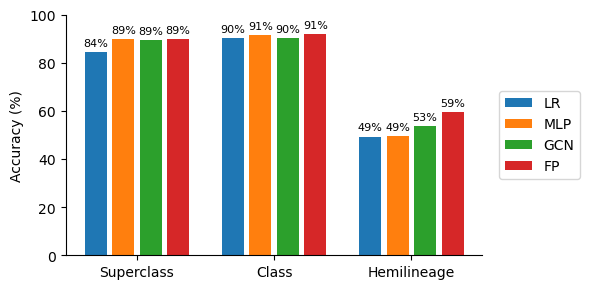

In [4]:
accuracies = {}
tasks = ["super_class", "class", "hemilineage"]
for model in results_both["model"].unique():
    sel_df = results_both[results_both["model"] == model].set_index("pred_target")
    accuracies[model.upper()] = list(sel_df.loc[tasks]["accuracy"])

x = np.arange(len(tasks))  # the label locations
width = 0.2  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)

for attribute, measurement in accuracies.items():
    # print(attribute)
    # print(measurement)
    offset = width * multiplier
    # print(x )
    rects = ax.bar(
        x + offset, np.array(measurement) * 100, width * 0.8, label=attribute.upper()
    )
    ax.bar_label(rects, padding=3, fmt="%d%%", fontsize=8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x + width * 2.5, [x.replace("_", "").title() for x in tasks])
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
ax.set_ylim(0, 100)
sns.despine()

plt.savefig("../figs/accuracy_bar.pdf")
plt.show()

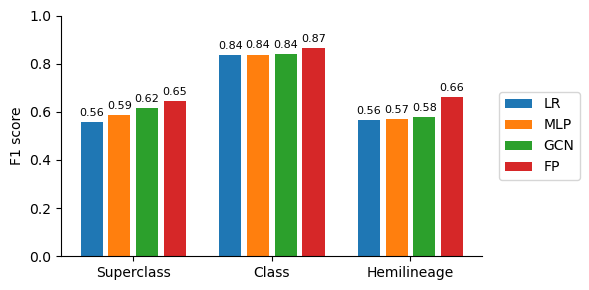

In [5]:
f1s = {}
for model in results_both["model"].unique():
    sel_df = results_both[results_both["model"] == model].set_index("pred_target")
    f1s[model.upper()] = list(sel_df.loc[tasks]["f1"])

x = np.arange(len(tasks))  # the label locations
width = 0.2  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)

for attribute, measurement in f1s.items():
    # print(attribute)
    # print(measurement)
    offset = width * multiplier
    # print(x )
    rects = ax.bar(
        x + offset, np.array(measurement), width * 0.8, label=attribute.upper()
    )
    ax.bar_label(rects, padding=3, fmt="%.2f", fontsize=8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 score')
ax.set_xticks(x + width * 2.5, [x.replace("_", "").title() for x in tasks])
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
ax.set_ylim(0, 1)
sns.despine()

plt.savefig("../figs/f1_bar.pdf")
plt.show()

### Confusion Matrix for FP

In [6]:
# load the data from the notebook 'exploitation.ipynb' . If the data is not found, please run the notebook first.
node_info_merged = pd.read_pickle(data_dir / "preprocessed/node_info_merged_non_std.pkl")

In [7]:
class_size_thrs = {"super_class": 100, "class": 100, "hemilineage": 200}
id2name_lookups = {}
name2id_lookups = {}

for pred_target, thr in class_size_thrs.items():
    # Remove minor classes
    counts = node_info_merged[pred_target].value_counts()
    valid_classes = counts[counts >= thr].index
    mask = node_info_merged[pred_target].isin(valid_classes)
    node_info_merged.loc[~mask, pred_target] = np.nan

    # Encode classes with integers (-1 == other classes)
    id2name = dict(enumerate(valid_classes))
    name2id = {v: k for k, v in id2name.items()}
    
    node_info_merged[pred_target] = [
        name2id[x] if x in valid_classes else -1
        for x in node_info_merged[pred_target].values
    ]
    id2name_lookups[pred_target] = id2name
    name2id_lookups[pred_target] = name2id

# Standardize feature columns
cols_to_standardize = [
    col for col in node_info_merged.columns
    if col.split("_")[0] in ("node2vec", "spectral", "morph")
]
scaler = StandardScaler()
scaler.fit(node_info_merged[cols_to_standardize])
node_info_merged[cols_to_standardize] = scaler.transform(
    node_info_merged[cols_to_standardize]
)

In [8]:
num_dims_per_nt = 8
nt_types = ["ACH", "GABA", "GLUT", "SER", "DA", "OCT"]

all_features = (
    [f"node2vec_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + [f"spectral_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + ["morph_length", "morph_area", "morph_size"]
)

both_mask = np.ones(len(all_features), dtype="bool")

pg_graph = pd.read_pickle(data_dir / "graphs/pg_graph.pkl")

In [9]:
class FastParapred(nn.Module):
    def __init__(self, in_dim, out_dim, features_mask):
        super(FastParapred, self).__init__()
        self.features_mask = features_mask
        self.features_mask = features_mask
        self.conv1 = gnn.GCNConv(in_dim, 32)
        # self.conv2 = gnn.GCNConv(64, 128)
        # self.conv3 = gnn.GCNConv(128, 256)
        self.att = gnn.GATv2Conv(32, 32)

        # self.att = gnn.GATv2Conv(256, 256)

        # self.classifier = gnn.Linear(256, out_dim)
        self.classifier = gnn.Linear(32, out_dim)

    def forward(self, data):
        x = data.x[:, features_mask]
        x = data.x[:, features_mask]
        conv_out = self.conv1(x, data.edge_index)
        x = F.relu(conv_out)
        # x = self.conv2(x, data.edge_index)
        # x = F.relu(x)
        # x = self.conv3(x, data.edge_index)
        # x = F.relu(x)
        atten_out = self.att(x, data.edge_index)
        x = self.classifier(conv_out + atten_out)
        return x


/var/folders/qx/mbfp35d17jz5g1qfw4xsv3yc0000gn/T/ipykernel_5240/3474808709.py:28: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(cmat))
/var/folders/qx/mbfp35d17jz5g1qfw4xsv3yc0000gn/T/ipykernel_5240/3474808709.py:28: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(cmat))
/var/folders/qx/mbfp35d17jz5g1qfw4xsv3yc0000gn/T/ipykernel_5240/3474808709.py:28: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(cmat))


<function matplotlib.pyplot.show(close=None, block=None)>

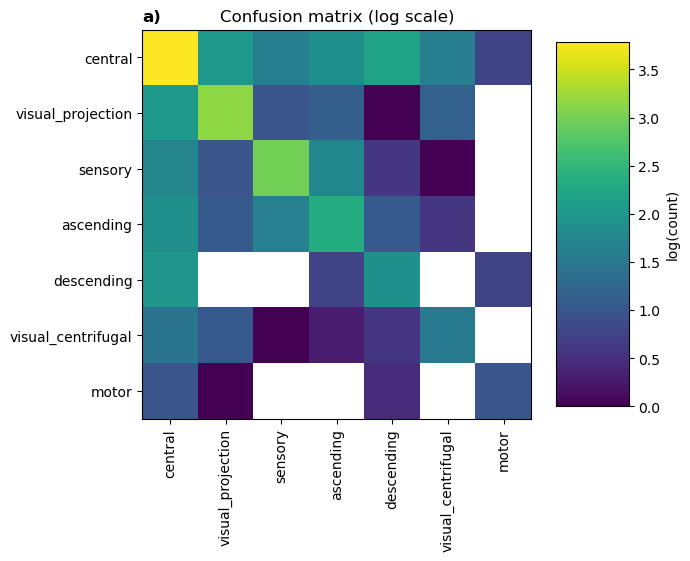

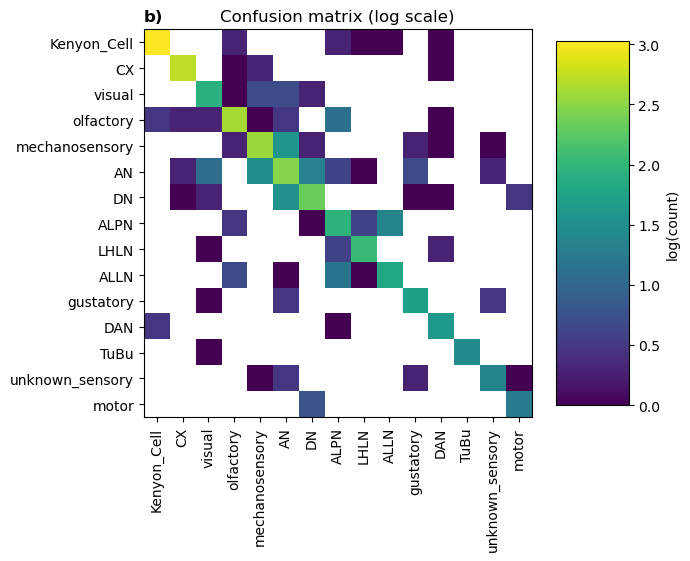

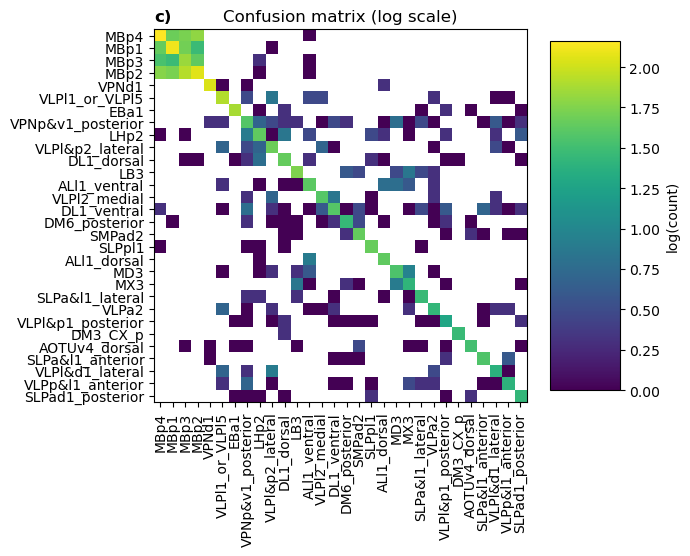

In [10]:


letters = ['a)', 'b)', 'c)']

for t,task in enumerate(tasks):
    pred_target = task
    features_group, features_mask = "both", both_mask

    fp_model = FastParapred(
        in_dim=int(features_mask.sum()),
        out_dim=len(id2name_lookups[pred_target]),
        features_mask=features_mask
    )

    fp_model.eval()
    model_path = models_dir / f"fp_{task}_both.pth"
    fp_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    test_mask = pg_graph.test_mask & (pg_graph[pred_target] != -1)

    fp_model.eval()
    pred = fp_model(pg_graph)[test_mask].argmax(dim=1).cpu().detach().numpy()
    label = pg_graph[pred_target][test_mask].cpu().detach().numpy()


    # Plot the Confusion Matrix

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), tight_layout=True)
    cmat = confusion_matrix(pred, label)
    ax.imshow(np.log10(cmat))
    colorbar = ax.figure.colorbar(ax.images[0], label="log(count)", aspect = 5)  # Updated colorbar usage
    ax.set_xticks(range(len(id2name_lookups[task])))  # Updated xticks usage
    ax.set_xticklabels([id2name_lookups[task][i] for i in range(len(id2name_lookups[task]))], rotation=90)  # Updated xticklabels usage
    ax.set_yticks(range(len(id2name_lookups[task])))  # Updated yticks usage
    ax.set_yticklabels([id2name_lookups[task][i] for i in range(len(id2name_lookups[task]))])  # Updated yticklabels usage
    ax.set_title("Confusion matrix (log scale)")  # Updated set_title usage
    ax.set_title(letters[t], loc="left", fontweight="bold")

    # save the figure as a pdf
    plt.savefig(f"../figs/confusion_matrix_{task}.pdf")

plt.show
